# HPGe Simulation

Importing libraries and initialising global constants

In [107]:
!apt-get update && apt-get install -y libgl1 libglu1-mesa

Hit:1 http://deb.debian.org/debian bookworm InRelease
Get:2 http://deb.debian.org/debian bookworm-updates InRelease [55.4 kB]
Get:3 http://deb.debian.org/debian-security bookworm-security InRelease [48.0 kB]
Get:4 http://deb.debian.org/debian-security bookworm-security/main amd64 Packages [170 kB]
Fetched 273 kB in 1s (277 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libdrm-amdgpu1 libdrm-common libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libdrm2 libelf1 libgl1-mesa-dri libglapi-mesa libglvnd0 libglx-mesa0 libglx0
  libllvm15 libopengl0 libsensors-config libsensors5 libx11-xcb1 libxcb-dri2-0
  libxcb-dri3-0 libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxfixes3 libxshmfence1 libxxf86vm1 libz3-4
Suggested packages:
  lm-sensors
The following NEW packages will be installed:
  libdrm-amdgpu1 libdrm-common 

In [109]:
!apt-get update && apt-get install -y libxrender1

Hit:1 http://deb.debian.org/debian bookworm InRelease
Hit:2 http://deb.debian.org/debian bookworm-updates InRelease
Hit:3 http://deb.debian.org/debian-security bookworm-security InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  libxrender1
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 33.2 kB of archives.
After this operation, 79.9 kB of additional disk space will be used.
Get:1 http://deb.debian.org/debian bookworm/main amd64 libxrender1 amd64 1:0.9.10-1.1 [33.2 kB]
Fetched 33.2 kB in 0s (707 kB/s)      
debconf: delaying package configuration, since apt-utils is not installed
Selecting previously unselected package libxrender1:amd64.
(Reading database ... 25481 files and directories currently installed.)
Preparing to unpack .../libxrender1_1%3a0.9.10-1.1_amd64.deb ...
Unpacking libxrender1:amd64 (1:0.9.10-1.1) ...
Setting

In [105]:
import openmc
import matplotlib.pyplot as plt

In [ ]:
europium_energy_peaks_ev = []

Creating settings

In [119]:
#materials
aluminium_mat = openmc.Material()
aluminium_mat.add_element('Al', 1, percent_type = 'ao')
aluminium_mat.set_density('g/cm3', 2.6989)

beryllium_mat = openmc.Material()
beryllium_mat.add_element('Be', 1, percent_type = 'ao')
beryllium_mat.set_density('g/cm3', 1.848)

copper_mat = openmc.Material()
copper_mat.add_element('Cu', 1, percent_type = 'ao')
copper_mat.set_density('g/cm3', 8.96)

germanium_mat = openmc.Material()
germanium_mat.add_element('Ge', 1, percent_type = 'ao')
germanium_mat.set_density('g/cm3', 5.323)

lead_mat = openmc.Material()
lead_mat.add_element('Pb', 1, percent_type = 'ao')
lead_mat.set_density('g/cm3', 11.35)

mylar_mat = openmc.Material()
mylar_mat.add_element('C', 10, percent_type = 'ao')
mylar_mat.add_element('H', 8, percent_type = 'ao')
mylar_mat.add_element('O', 4, percent_type = 'ao')
mylar_mat.set_density('g/cm3', 1.38)

materials = openmc.Materials([aluminium_mat, beryllium_mat, copper_mat, germanium_mat, lead_mat, mylar_mat])
materials.export_to_xml()

In [134]:
#surfaces

lead_shield_out = openmc.model.RightCircularCylinder([0, 0, -28], 61, 28.5, axis = 'z', boundary_type = 'vacuum')
lead_shield_in = openmc.model.RightCircularCylinder([0, 0, -23], 46, 12.5, axis = 'z')

# outer_cylinder_out = openmc.model.RightCircularCylinder([0, 0, -46], 46, 12.5, axis = 'z', boundary_type = 'vacuum')
# outer_cylinder_in = openmc.model.RightCircularCylinder([0, 0, -46], 45.9, 12.4, axis = 'z')

outer_cylinder_out = openmc.model.RightCircularCylinder([0, 0, -28], 28, 10, axis = 'z')
outer_cylinder_in = openmc.model.RightCircularCylinder([0, 0, -28], 27.9, 9.9, axis = 'z')
#outer_cylinder_in = openmc.model.RightCircularCylinder([0, 0, -28], 27, 9.5, axis = 'z') #visualisation

aluminium_case_out = openmc.model.RightCircularCylinder([0, 0, -11], 10.5, 9, axis = 'z')
#aluminium_case_in = openmc.model.RightCircularCylinder([0, 0, -10.7], 9, 8, axis = 'z') #visualisation
aluminium_case_in = openmc.model.RightCircularCylinder([0, 0, -10.7], 10.2, 8.92, axis = 'z')

aluminium_layer = openmc.model.RightCircularCylinder([0, 0, -0.506], 0.003, 9, axis = 'z')
mylar_layer = openmc.model.RightCircularCylinder([0, 0, -0.503], 0.003, 9, axis = 'z')

germanium_crystal = openmc.model.RightCircularCylinder([0, 0, -5.543], 5.03, 7.07, axis = 'z')

interior_hole_cylinder = openmc.model.RightCircularCylinder((0, 0, -46), 43.704, 0.44, axis = 'z')
#interior_hole_cylinder = openmc.model.RightCircularCylinder((0, 0, -12), 9.704, 0.44, axis = 'z') #visualisation
interior_hole_sphere = openmc.Sphere(0, 0, -2.356, 0.44)

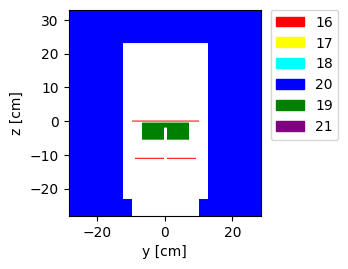

In [135]:
colour_assignment = {aluminium_mat: 'red', beryllium_mat: 'yellow', copper_mat: 'cyan', lead_mat: 'blue', germanium_mat: 'green', mylar_mat: 'purple'}

lead_shield_region = -lead_shield_out & +lead_shield_in & +outer_cylinder_out
lead_shield_cell = openmc.Cell(region = lead_shield_region)
lead_shield_cell.fill = lead_mat

outer_cylinder_region = -outer_cylinder_out & +outer_cylinder_in & +interior_hole_cylinder & +interior_hole_sphere
outer_cylinder_cell = openmc.Cell(region = outer_cylinder_region)
outer_cylinder_cell.fill = aluminium_mat

aluminium_case_region = -aluminium_case_out & +aluminium_case_in & +interior_hole_cylinder & +interior_hole_sphere #& -aluminium_layer & -mylar_layer
aluminium_case_cell = openmc.Cell(region = aluminium_case_region)
aluminium_case_cell.fill = aluminium_mat

aluminium_layer_region = -aluminium_layer
aluminium_layer_cell = openmc.Cell(region = aluminium_layer_region)
aluminium_layer_cell.fill = aluminium_mat

mylar_layer_region = -mylar_layer
mylar_layer_cell = openmc.Cell(region = mylar_layer_region)
mylar_layer_cell.fill = mylar_mat

germanium_crystal_region = -germanium_crystal & +interior_hole_cylinder & +interior_hole_sphere
germanium_crystal_cell = openmc.Cell(region = germanium_crystal_region)
germanium_crystal_cell.fill = germanium_mat

geometry = openmc.Geometry([lead_shield_cell, outer_cylinder_cell, aluminium_case_cell, germanium_crystal_cell, aluminium_layer_cell, mylar_layer_cell])
plot = geometry.plot(basis = 'yz', color_by = 'material', colors = colour_assignment, legend = True)

geometry.export_to_xml()

In [110]:
# makes the 3d "cube" style geometry
vox_plot = openmc.Plot()
vox_plot.type = 'voxel'

# makes sure the bounds of the plot include the whole geometry
vox_plot.width = geometry.bounding_box.width

# makes sure the voxel plot is centered at the center of the geometry
vox_plot.origin = geometry.bounding_box.center

# sets the pixels in each direction to be proportional to the size of the geometry in that direction
# Your computer RAM will limit the number of pixels you can set in each direction.
# The * 0.1 part of this line reduces the number of pixels in each direction to a reasonable amount but this could be increased if you want more resolution.
vox_plot.pixels = [int(w* 0.1) for w in geometry.bounding_box.width]

vox_plot.color_by = 'material'

vox_plot.to_vtk(output='voxel_plot.vti')

'voxel_plot.vti'

In [113]:
settings = openmc.Settings()
settings.batches = 10
settings.particles = 1000
settings.run_mode = 'fixed source'

source = openmc.IndependentSource()
source.space = openmc.stats.Point((0,0,0))
source.angle = openmc.stats.Isotropic()
source.energy = openmc.stats.Discrete([14e6], [1])
settings.source = source

In [ ]:
mesh = openmc.RegularMesh().from_domain(geometry)
mesh.dimension = (500, 500, 1)
mesh.filter = openmc.MeshFilter(mesh, filter_id = 1)

surface_filter = openmc.SurfaceFilter(outer_cylinder_region)
energy_filter = openmc.EnergyFilter(energies)

tally = openmc.Tally(name = 'neutron_flux_tally')
tally.filters = [surface_filter, energy_filter]
tally.scores = ['current']
tallies = openmc.Tallies()
tallies.append(tally)
tallies.export_to_xml()